# Logistic Regression (Juices dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/juices/FTIR_juices.csv')
data.head(5)

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,label
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry
2,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007,NON-Strawberry
3,0.002345,0.002292,0.002249,0.002303,0.002466,0.002642,0.002703,0.002671,0.002618,0.002567,...,0.000419,0.000267,0.000179,0.000119,0.000075,0.000043,0.000021,0.000008,0.000008,NON-Strawberry
4,0.002303,0.002342,0.002350,0.002419,0.002561,0.002737,0.002862,0.002860,0.002811,0.002750,...,0.000468,0.000299,0.000212,0.000140,0.000099,0.000054,0.000020,0.000012,0.000012,NON-Strawberry


In [4]:
# shuffle data rows
data = data.sample(frac=1)

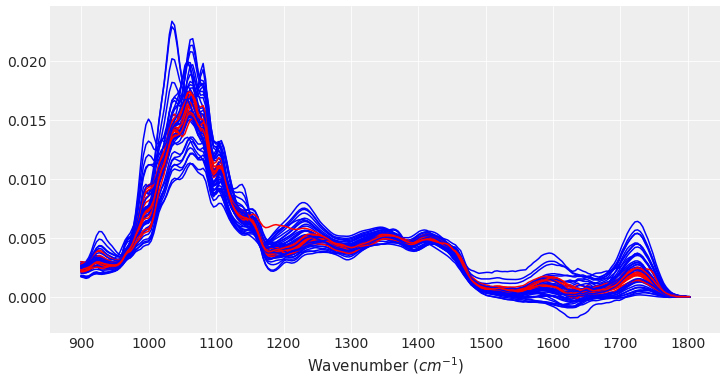

In [5]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
ndata_cols = -1

# list of class labels
clabels = list({lbl for lbl in data.iloc[:,data.columns.to_list().index(label_col)].tolist()})
clabels.sort()

# plot dataframe
utl.plot_data(data, ndata_cols, label_col, 50)

In [6]:
# number of samples from each class
data[label_col].value_counts()

NON-Strawberry    632
Strawberry        351
Name: label, dtype: int64

In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(325, 236)

In [9]:
train_data.shape

(658, 236)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [10]:
# get Y labels and standardize data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:ndata_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [11]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [1:14:59<00:00,  1.11draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


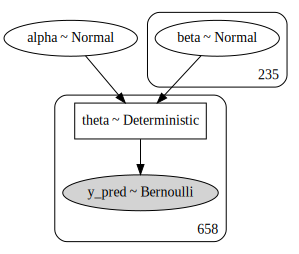

In [12]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [13]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-19.802,2.892,-25.384,-14.664,0.050,0.036,3298.0,3161.0,3382.0,3282.0,1.0
beta[0],-1.405,7.085,-14.898,11.541,0.099,0.117,5112.0,1841.0,5086.0,2865.0,1.0
beta[1],-5.194,7.520,-19.376,9.180,0.103,0.112,5379.0,2255.0,5378.0,2656.0,1.0
beta[2],-5.055,8.419,-20.949,10.466,0.105,0.129,6371.0,2141.0,6369.0,2341.0,1.0
beta[3],-0.368,8.744,-15.852,16.485,0.105,0.145,6983.0,1820.0,6968.0,3227.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[230],-2.657,7.894,-17.463,11.709,0.109,0.134,5222.0,1744.0,5314.0,2989.0,1.0
beta[231],-3.155,6.093,-15.047,7.989,0.092,0.083,4358.0,2692.0,4384.0,2866.0,1.0
beta[232],-11.507,5.320,-21.220,-1.332,0.079,0.061,4574.0,3766.0,4594.0,2617.0,1.0
beta[233],-10.703,4.957,-20.414,-1.960,0.076,0.058,4252.0,3602.0,4288.0,2616.0,1.0


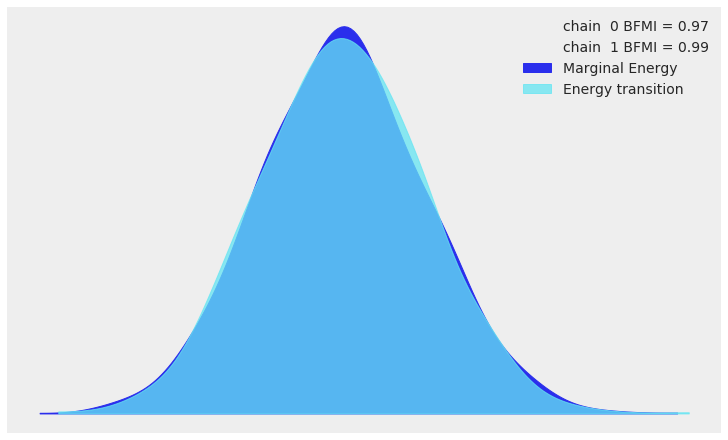

In [14]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [15]:
# check model predictions on test dataset
utl.display_predictions(trace_mlr, test_data, ndata_cols, clabels)

              label  pred      pred_label
0    NON-Strawberry   0.0  NON-Strawberry
1    NON-Strawberry   0.0  NON-Strawberry
2        Strawberry   1.0      Strawberry
3    NON-Strawberry   0.0  NON-Strawberry
4    NON-Strawberry   0.0  NON-Strawberry
..              ...   ...             ...
320  NON-Strawberry   0.0  NON-Strawberry
321  NON-Strawberry   0.0  NON-Strawberry
322      Strawberry   1.0      Strawberry
323      Strawberry   1.0      Strawberry
324      Strawberry   1.0      Strawberry

[325 rows x 3 columns]


In [18]:
# prediction score on test dataset
utl.logistic_score(test_data, label_col, test_data.iloc[:,-1])

total  : 325
correct: 325
error  : 0
score  : 100.0%


# Save inference results

In [19]:
pm.backends.text.dump('./traces/trace_juices', trace_mlr)